## Nested Sampling In NumPyro with JAXNS
So far, we've seen that none of NumPyro's native MCMC samplers work particularly [well in multimodal distributions](../03_mcmcsamplers/page.html). Though they may locate the modes decently well, they fail to sample from them in a representative way, inflating the smaller modes by over-sampling them.  Fortunately, we have another tool at our disposal that is purpose built for multimodal distributions: [Nested Sampling](https://en.wikipedia.org/wiki/Nested_sampling_algorithm) (NS). In this article, we'll go over the basics of how to use NumPyro's integration of `JAXNS`, a nested sampling implementation, pitting it against a simple 2D multimodal distribution and looking at the different features we have for tuning and diagnosing our results.

In [1]:
# Statistical + JAX Tools
import jaxns as jn
import jax
import numpyro
import jax.numpy as jnp
from numpyro.contrib.nested_sampling import NestedSampler

# Utility, Math & Plotting
import numpy as np
import matplotlib.pyplot as plt
from chainconsumer import ChainConsumer

2024-02-22 14:31:44.478144: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-22 14:31:44.478282: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-22 14:31:44.478945: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-22 14:31:45.409415: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
INFO[2024-02-22 14:31:46,826]: Unable to initialize backend 'cuda': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO[2024-02-22 14:31:46,827]: Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has 

In the strictest sense, NS is an _integrator_ rather than a true MCMC method, but its results can be easily weighted into a MCMC-like chain. However, because it takes many samples in the low probability regions of parameter space to properly map where the likelihood _isn't_
it tends to produce "rougher" contours for the same number of samples.

I have a more detailed writeup of the interface / mechanisms of NS in NumPyro over [here](../../03_stats/04_nestedsampling/page.html), but the central idea behind NS is:
1. Generate a set of $N$ "Live Points", distributed evenly across the prior
2. Remove the first point and log it as a sample
3. Find another point drawn _uniformly_ from the regions of parameter space at _higher likelihood_ than this dead point
4. Repeat the last two steps until the ensemble has converged to a small volume

The idea here is that removing the $N^{th}$ point in your "Live Points" will shrink the volume subtended by your ensemble by a factor of $\approx 1-1/N$. E.g. if we have $100$ live points and remove the worst one, the volume should contract by about $1 \%$. Because we know the likelihood of each dead point and have this estimate of the volume at at similar likelihoods, we can re-weight our chain of dead points to get an MCMC-like output. 

I've emphasized some points in step $3.$ because this is a deceptively complicated thing to do efficiently: going uphill locally is easy, but going anywhere uphill with equal unbiased probability is very hard. Various NS implementations rely on mixed of slice sampling or clever clustering algorithms to accomplish this, and NumPyro has an interface to [JAXNS](https://github.com/Joshuaalbert/jaxns) in its `numpyro.contrib` module, a JAX-based nested sampling algorithm that we can use out of the box.

---


As an example, we'll use a simple 2D multimodal likelihood distribution with a uniform prior. I.e. imagine a posterior distribution that obeys:

$$
    P(x,y)  \propto \mathcal{N}(x+2) + \mathcal{N}(x-2)
$$
With uniform prior boundaries:

$$
    x\in [-5,5], y\in[-2.5,2.5]
$$

We'll later check how `JAXNS` handles normalization, so note that the volume of the prior is:

$$
    V=\Delta x \cdot \Delta y = 20 \cdot 10=200
$$

I've also scaled the function such the total evidence / area under the curve has been set to $Z=3$:

In [2]:
# Prior Width
xmin,xmax = -5, 5
ymin,ymax = -2.5,2.5
V0 = (xmax-xmin) * (ymax-ymin)

Ztrue = 3.0

# Define likelihood function:
def prob_func(x,y):
    # Two gaussian modes
    out=0
    out+=jnp.exp(-(x - 2)**2-y**2) 
    out+=jnp.exp(-(x + 2)**2-y**2)

    # Normalizing
    out/=2*np.pi
    out*=Ztrue
    return(out)
    
def log_prob_func(x,y):
    return(jnp.log(prob_func(x,y)))

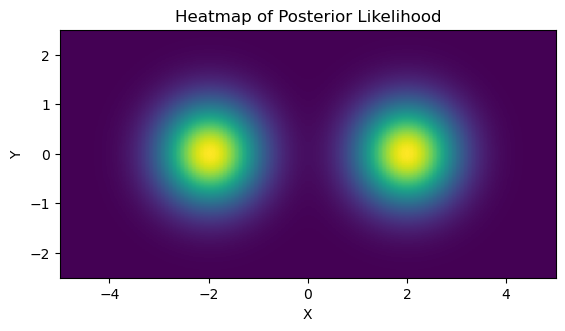

In [3]:
# REDACT
#---------------------
# Generate grid of likelihoods
Ngrid = 128
dx, dy = (xmax-xmin)/(Ngrid-1), (ymax-ymin)/(Ngrid-1)
Xgrid, Ygrid = np.meshgrid(np.linspace(xmin,xmax,Ngrid), np.linspace(ymin,ymax,Ngrid))
heatmap_grid =prob_func(Xgrid,Ygrid)

#---------------------
# Plot heatmap of likelihood
def do_heatmap(cmap = 'viridis', contrast = 1, clipping=[0,1], interpolation = 'antialiased'):
    fig, ax = plt.subplots(1,1)
    ax.imshow(heatmap_grid**contrast, extent=[xmin,xmax,ymin,ymax], 
              cmap = cmap, 
              vmin = heatmap_grid.max()*clipping[0], 
              vmax = heatmap_grid.max()*clipping[1], 
              interpolation = interpolation,
              zorder=-10)
    ax.set_title("Heatmap of Posterior Likelihood")
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    return(fig, ax)
fig, ax = do_heatmap()
plt.show()


We can confirm this is working with a direct grid integration:

In [4]:
#---------------------
# Generate grid of likelihoods
Ngrid = 128
dx, dy = (xmax-xmin)/(Ngrid-1), (ymax-ymin)/(Ngrid-1)
Xgrid, Ygrid = np.meshgrid(np.linspace(xmin,xmax,Ngrid), np.linspace(ymin,ymax,Ngrid))
heatmap_grid =prob_func(Xgrid,Ygrid)

#---------------------
# Do integral / summation
Zgrid = np.sum(heatmap_grid) / np.sum(heatmap_grid>0) * V0
print("Evidence from grid integration is %0.4f, an error of %0.2f%% with %i evaluations" %(Zgrid,abs(Zgrid/Ztrue-1)*100, Ngrid**2) )


Evidence from grid integration is 2.9522, an error of 1.59% with 16384 evaluations


Now onto the fun part: attacking this distribution with nested sampling. Because this is just an example, we'll cheat a bit and feed our `log_prob_func` directly into a NumPyro model using `numpyro.factor`:

In [5]:
def np_model():
    x = numpyro.sample('x', numpyro.distributions.Uniform(xmin,xmax))
    y = numpyro.sample('y', numpyro.distributions.Uniform(ymin,ymax))
    numpyro.factor(name="prob_fac", log_factor = log_prob_func(x,y))

Now we can create and run the sampler as we would a normal MCMC sampler in NumPyro. The unlike MCMC, the tuning parameters are passed in the form of dictionaries: `constructor_kwargs` and `termination kwargs`. Though `JAXNS` has a lot of tunable parameters under these two umbrellas, only a small subset are available via the NumPyro implementation (at time of writing). We'll see the full list below, but the most important are the number of **live points**, which acts like the resolution of our sampling, and the **live evidence fraction**, which controls when the sampling terminates. The **max samples** is a safety limit, and doesn't affect our answer much. I've set it conservatively high to ensure convergence.

In [6]:
NS = NestedSampler(model=np_model, 
                   constructor_kwargs={'num_live_points': 5000, 'max_samples': 50000},
                   termination_kwargs={'live_evidence_frac': 0.01}
                  )
NS.run(jax.random.PRNGKey(0))

If you're looking to use nested sampling as a multi-modal friendly MCMC alternative, the next step should be familiar: just draw a chain of samples from the sampling object and feed it to your favourite corner plotter. The only change from NUTS or SA is that we need to feed a random seed and ask for a specific number of samples for `NestedSampler.get_samples()`. This is because nested sampling doesn't generate an MCMC-like chain of samples, and has to use a weighted re-sampling to acquire one.

WARNING[2024-02-22 14:31:56,679]: Parameter x in chain Chain 0 is not constrained


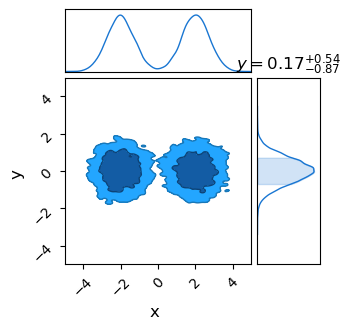

In [7]:
# Weighted MCMC-like samples. Can draw as many samples as we want, but will draw the same point multiple times
weighted_samps = NS.get_samples(jax.random.PRNGKey(1), int(1E4))

#=========================================
c = ChainConsumer()
c.add_chain(weighted_samps)
c.plotter.plot(extents={'x':[xmin,xmax], 'y':[-5,5]})
plt.show()

Unlike an MCMC algorithm, Nested Sampling's chain of accepted samples is _not_ distributed representatively across the posterior. Instead, samples are weighted by both their likelihood and the volume of parameter space that they are an integral proxy for to get an MCMC-like chain. Confusingly, the function to call these _weighted_ samples is called `get_samples`, while the _unweighted_ chain is acquired via `get_weighted samples`. The NS-like samples are spread all across the prior range, MCMC-like samples are distributed near the modal peaks.

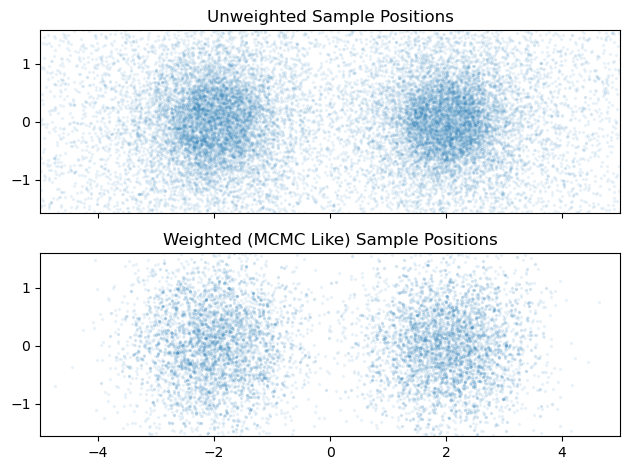

In [8]:
# Un-weighted nested sampling-like chain. Returns _all_ samples from the NS algorithm, and has an unpredictable length
unweighted_samps = NS.get_weighted_samples()

#=========================================
fig2, ax2 = plt.subplots(2,1, sharex=True)

ax2[0].scatter(unweighted_samps[0]['x'],unweighted_samps[0]['y'],alpha=0.1, s = 2, marker='x')
ax2[1].scatter(weighted_samps['x'],weighted_samps['y'], alpha=0.1, s = 2, marker='x')

ax2[0].axis('equal')
ax2[1].axis('equal')

ax2[0].set_title("Unweighted Sample Positions")
ax2[1].set_title("Weighted (MCMC Like) Sample Positions")
plt.xlim(-5,5)

fig2.tight_layout()

plt.show()

----
## Diagnostics & Results

If we were only concerned with using NS like an MCMC sampler, this is as far as we'd need to go. However, there are a few other utilities on hand: some available up front, and some buried as internal functions.

We can get a plain-text summary of the integration results and efficiency using the `print_summary()` method, and can get some traditional plots showing the integral convergence using `.diagnostics()`. These graphs are a good check for the reliability of your results: if the curves are noisy you likely have too few live points, if they seem weirdly shaped try tightening the termination conditions or increase the maximum number of samples. 

In [9]:
NS.print_summary()

--------
Termination Conditions:
Small remaining evidence
--------
# likelihood evals: 132502
# samples: 21513
# slices: 25000.0
# slices / acceptance: 5.0
# likelihood evals / sample: 6.2
# likelihood evals / slice: 3.3
--------
logZ=-2.826 +- 0.035
H=3.1
ESS=8738
--------
x: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
x: 0.0 +- 2.1 | -2.6 / 0.6 / 2.6 | -2.0 | -2.0
--------
y: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
y: 0.02 +- 0.7 | -0.87 / 0.01 / 0.93 | -0.01 | -0.01
--------


WARNING[2024-02-22 14:31:58,002]: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


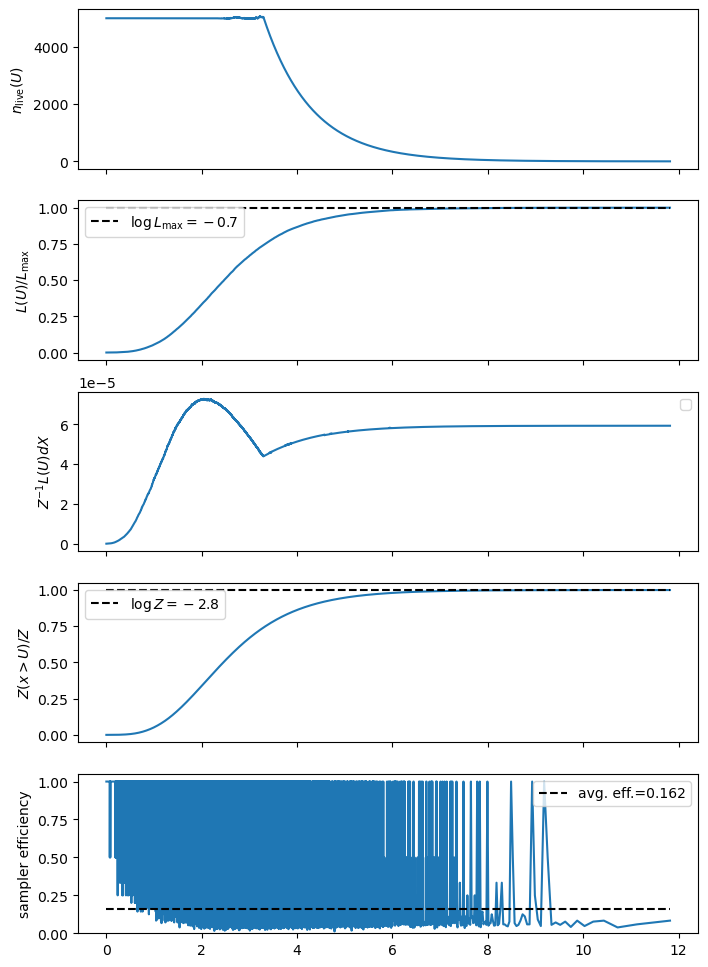

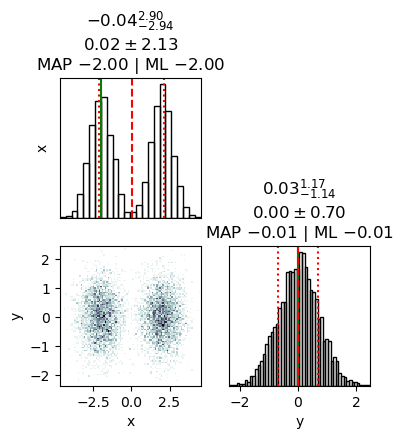

In [10]:
NS.diagnostics()

We can also check the full set of tunable parameters for the `NestedSampler` object, including default values for ones that we didn't specify:

In [11]:
print("constructor_kwargs")
for key in NS.constructor_kwargs: print("\t"+str(key)+":\t"+str(NS.constructor_kwargs[key]))
print("termination_kwargs")
for key in NS.termination_kwargs: print("\t"+str(key)+":\t"+str(NS.termination_kwargs[key]))

constructor_kwargs
	num_live_points:	5000
	max_samples:	50000
	num_parallel_samplers:	1
	uncert_improvement_patience:	2
termination_kwargs
	live_evidence_frac:	0.01


To get a hold of the integration result themselves, we have to dig into the internals of the `NS` object. The samples, weights and results are stored in the `._results` component:

In [12]:
print("Contents of NS._results:")
for a in dir(NS._results): 
    if "_" not in a: 
        print("\t",a)

Contents of NS._results:
	 ESS
	 count
	 index
	 samples


For our purposes, we are interested only in the evidence, which is here available in log-form. Note the total evidence that `JAXNS` spits out is off by a factor of $200$. This is because `JAXNS` has no knowledge of the prior volume: it always assumes a value of unity, i.e. $V=1.0$. Mostly we only care about evidence in the context of model comparison, so we can ignore this as long as our models all have the same prior. If they don't, we'll have to correct by a factor of volume before getting our evidence ratios.

In [13]:
# Extract log-evidence & Uncertainty
Lz_mean = NS._results.log_Z_mean
Lz_uncert = NS._results.log_Z_uncert

# Convert back from log
Z_NS = np.exp(np.array([Lz_mean-Lz_uncert,Lz_mean,Lz_mean+Lz_uncert]))

#------
print("Evidence directly from JAXNS: \n\t min, \t mean, \tmax")
print("\t %.2f \t %.2f \t %.2f" %(Z_NS[0],Z_NS[1],Z_NS[2]))

print("Evidence after correcting for volume: \n\t min, \t mean, \tmax")
print("\t %.2f \t %.2f \t %.2f" %(Z_NS[0]*V0,Z_NS[1]*V0,Z_NS[2]*V0))

Evidence directly from JAXNS: 
	 min, 	 mean, 	max
	 0.06 	 0.06 	 0.06
Evidence after correcting for volume: 
	 min, 	 mean, 	max
	 2.86 	 2.96 	 3.07


Also keep in mind that nested sampling has a few halting conditions: unlike HMC where we go until `num_samples` has been reached, nested sampling can halt when its integral has converged. We can find the reason for the sampler termination in the `._results.termination_reason` object. The codes are as follows: we ideally want `termination_reason == 2` or `termination_reason == 4`. The important feature is that *odd* termination codes indicate that the integration has timed out due to a maximum number of samples. If this happens, it indicates that we need to increase the `max_evals` in our sampler.

        0-bit -> 1: used maximum allowed number of samples
        1-bit -> 2: evidence uncert below threshold
        2-bit -> 4: live points evidence below threshold
        3-bit -> 8: effective sample size big enough
        4-bit -> 16: used maxmimum allowed number of likelihood evaluations
        5-bit -> 32: maximum log-likelihood contour reached
        6-bit -> 64: sampler efficiency too low
        7-bit -> 128: entire live-points set is a single plateau

Checking for our example case, we can see that it ended with a code of `termination_reason==4`. This is good, it means that it timed out because the integral had converged as converged such that adding more nested samples wasn't contributing any more precision.

In [14]:
print("Termination Condition:")
print("\t",int(NS._results.termination_reason))

Termination Condition:
	 4


Be aware that this only means that we've wrung as much precision as possible out of the function _near the peak likelihood_, it doesn't guarantee that we have an accurate integral across the entire domain. For that, we need to check how our diagnostic curves are looking, as above.